In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from similarity_searching_sketches.multi_hash_index_stats import ListStatsCounter
from similarity_searching_sketches.multi_hash_index_stats import bucket_stats
from similarity_searching_sketches.multi_hash_index_stats import bucket_sizes
from similarity_searching_sketches.multi_hash_index_stats import stats_to_pandas
from similarity_searching_sketches.multi_hash_index_stats import rq_candidate_set_size_stats
from similarity_searching_sketches.multi_hash_index import MultiHashIndex
from similarity_searching_sketches.persistence import load_np_array
from similarity_searching_sketches.utils import df_to_latex
from similarity_searching_sketches.visualization import hist_array
from similarity_searching_sketches.visualization import plot_array
%matplotlib inline

In [2]:
DATA_FOLDER='/home/matej/data/sketch-testing/dataset_10K/'
PIVOTS_PATH=DATA_FOLDER+'selected_pivots.npy'
MHI_DB_SAVE_PATH=DATA_FOLDER+'mhi_sketch_db.npy'
BUCKET_STATS_LATEX_SAVE_FILE=DATA_FOLDER+'bucket_stats.tex'
CANDIDATE_SET_SIZE_STATS_LATEX_SAVE_FILE=DATA_FOLDER+'candidate_set_size_stats.tex'
SKETCH_LEN=32
N_QUERY_OBJS=100
MAX_M=8

#### Prepare Sketch DB

In [3]:
sketch_db=load_np_array(MHI_DB_SAVE_PATH).T[:SKETCH_LEN].T

In [4]:
ids=np.arange(sketch_db.shape[0])

In [5]:
db=[(ids[i],sketch_db[i]) for i in range(sketch_db.shape[0])]
random.shuffle(db)
queries=db[:N_QUERY_OBJS]
sketch_db=db[N_QUERY_OBJS:]
del db

In [6]:
sketch_db[:2]

[(216,
  array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
         1, 0, 1, 1, 1, 1, 1, 0, 1])),
 (786,
  array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
         1, 1, 1, 1, 1, 1, 0, 0, 1]))]

In [7]:
len(sketch_db)

9900

#### Initialize MHI's

In [8]:
m_list=range(1,MAX_M+1,1)
mhis=[MultiHashIndex(sketch_db, m) for m in m_list]

#### Compute stats  for MHI's buckets

In [9]:
bucket_stats_keys, bucket_stats=bucket_stats(mhis, m_list)

In [10]:
bucket_stats_df=stats_to_pandas(bucket_stats_keys, bucket_stats)

/home/matej/project/similarity-searching-sketches/similarity_searching_sketches/multi_hash_index_stats.py:21: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  return pd.DataFrame.from_dict({key: stats[key] for key in keys}).reindex_axis(keys, axis=1)


In [11]:
bucket_stats_df

,m,r,Bucket count,Bucket size mean,Bucket size st. dev.,Bucket size sum,m x Bucket size mean
0,1,0,9836,1.006507,0.080401,9900,1.006507
1,2,1,11327,1.748036,1.707665,19800,3.496071
2,3,2,3543,8.382727,14.395340,29700,25.148180
3,4,3,996,39.759036,57.087478,39600,159.036145
4,5,4,447,110.738255,138.101771,49500,553.691275
5,6,5,256,232.031250,259.514434,59400,1392.187500
6,7,6,176,393.750000,386.511106,69300,2756.250000
7,8,7,128,618.750000,511.015044,79200,4950.000000


In [12]:
df_to_latex(BUCKET_STATS_LATEX_SAVE_FILE,bucket_stats_df)

#### Visualize bucket sizes

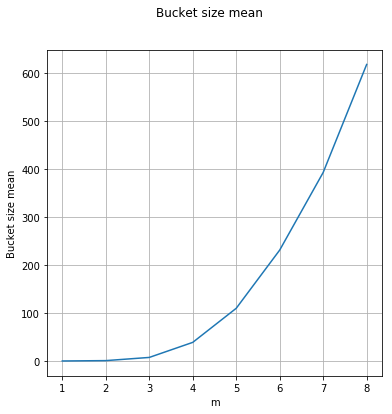

In [13]:
plot_array([None]+list(bucket_stats_df['Bucket size mean'].values), title='Bucket size mean', xlabel='m', ylabel='Bucket size mean', figsize=(6,6))

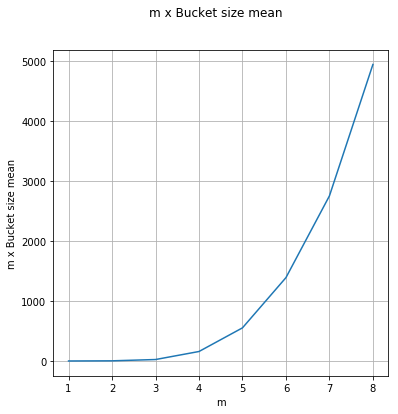

In [14]:
plot_array([None]+list(bucket_stats_df['m x Bucket size mean'].values), title='m x Bucket size mean', xlabel='m', ylabel='m x Bucket size mean', figsize=(6,6))

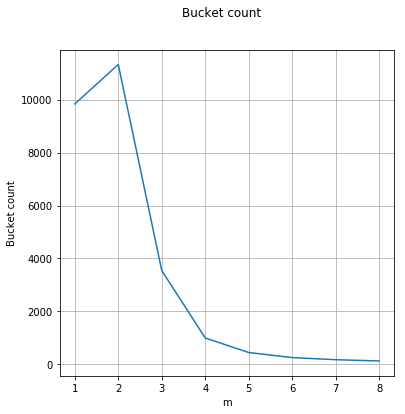

In [15]:
plot_array([None]+list(bucket_stats_df['Bucket count'].values), title='Bucket count', xlabel='m', ylabel='Bucket count', figsize=(6,6))

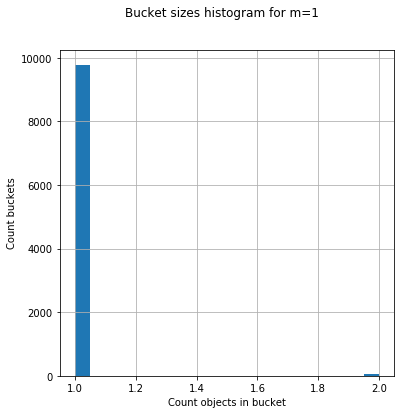

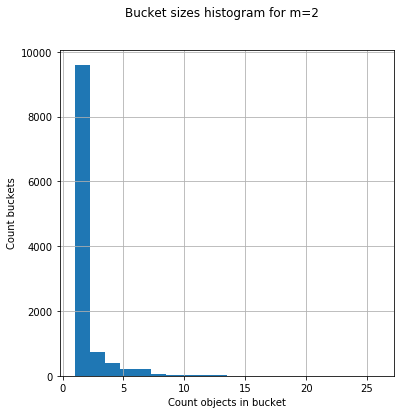

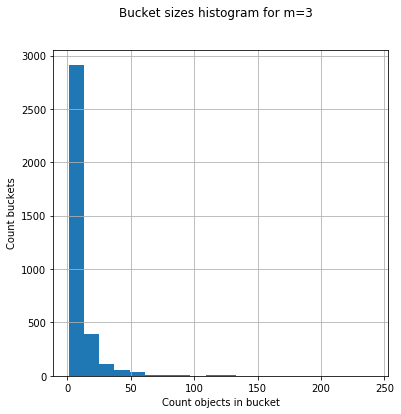

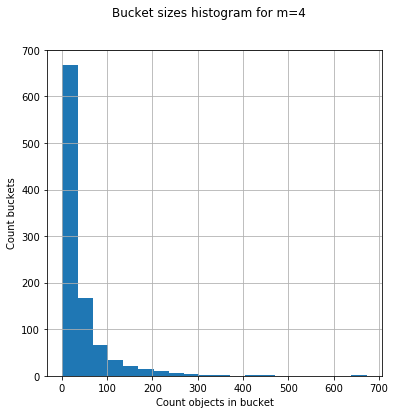

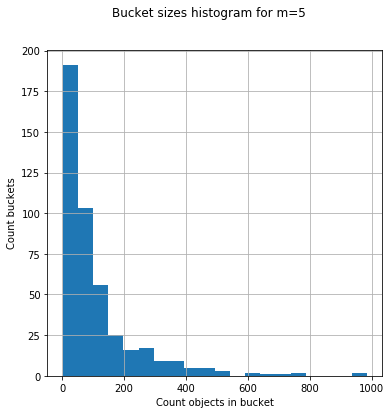

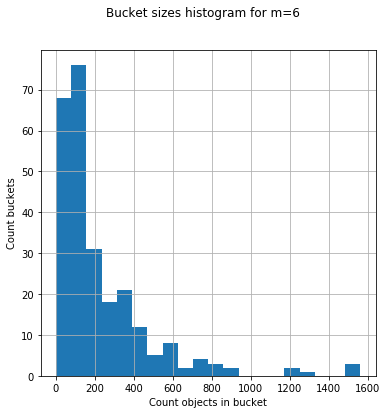

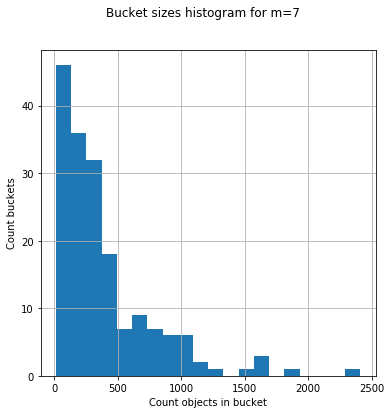

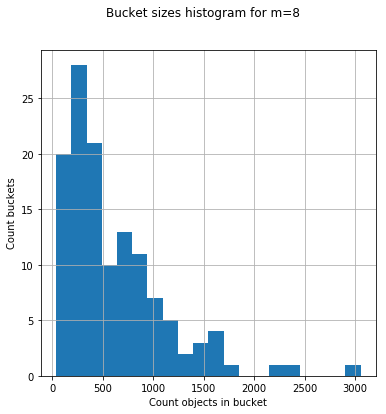

In [16]:
for i,mhi in enumerate(mhis):
    m=m_list[i]
    hist_array(bucket_sizes(mhi), bins=20, title='Bucket sizes histogram for m='+str(m), xlabel='Count objects in bucket', ylabel='Count buckets', figsize=(6,6))
    
    

#### Range query candidate set sizes

In [17]:
keys,stats=rq_candidate_set_size_stats(queries, mhis, m_list)
candidate_set_stats_df=stats_to_pandas(keys,stats)

/home/matej/project/similarity-searching-sketches/similarity_searching_sketches/multi_hash_index_stats.py:21: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  return pd.DataFrame.from_dict({key: stats[key] for key in keys}).reindex_axis(keys, axis=1)


In [18]:
candidate_set_stats_df

,m,r,m x Bucket size mean,Mean |C_1|+...+|C_m|,Mean |C|,Mean % filtered out
0,1,0,1.006507,0.05,0.05,0.000000
1,2,1,3.496071,4.85,4.80,1.030928
2,3,2,25.148180,98.79,97.16,1.649965
3,4,3,159.036145,455.11,439.45,3.440926
4,5,4,553.691275,1430.71,1316.73,7.966674
5,6,5,1392.187500,3109.88,2660.55,14.448467
6,7,6,2756.250000,5437.84,4171.26,23.291969
7,8,7,4950.000000,8224.05,5591.59,32.009290


In [19]:
df_to_latex(CANDIDATE_SET_SIZE_STATS_LATEX_SAVE_FILE, candidate_set_stats_df)

/home/matej/project/similarity-searching-sketches/similarity_searching_sketches/multi_hash_index_stats.py:21: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  return pd.DataFrame.from_dict({key: stats[key] for key in keys}).reindex_axis(keys, axis=1)


Text(0,0.5,"Count object ID's")

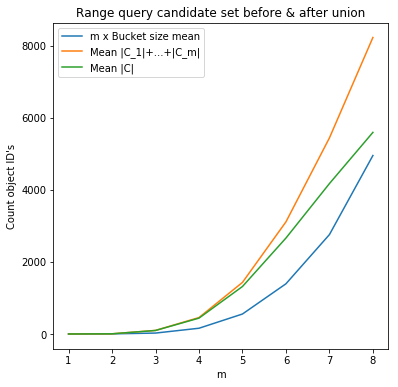

In [20]:
candidate_set_stats_df_with_m0=stats_to_pandas(keys, {key:[None]+stats[key] for key in stats.keys()})
candidate_set_stats_df_with_m0[['m x Bucket size mean','Mean |C_1|+...+|C_m|','Mean |C|']].plot(figsize=(6,6))
plt.title('Range query candidate set before & after union')
plt.xlabel('m')
plt.ylabel('Count object ID\'s')